## Predicting Home Loans

Source: https://www.kaggle.com/ufffnick/loan-prediction-dream-housing-finance   
Data: https://www.kaggle.com/burak3ergun/loan-data-set

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes
import pickle

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

### import data

In [55]:
df = pd.read_csv('../data/loan_data_set.csv')
data_set=df.copy()
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


## Exploratory Data Analysis

In [56]:
# target variable: Approval of Mortgage Loan
print(data_set[['Loan_Status']].value_counts())

Loan_Status
Y              422
N              192
dtype: int64


In [57]:
# categorical variables
print('\n',data_set[['Loan_Amount_Term']].value_counts().head())
print('\n',data_set[['Property_Area']].value_counts())
print('\n',data_set[['Gender']].value_counts())
print('\n',data_set[['Education']].value_counts())
print('\n',data_set[['Self_Employed']].value_counts())
print('\n', data_set[['Credit_History']].value_counts())


 Loan_Amount_Term
360.0               512
180.0                44
480.0                15
300.0                13
84.0                  4
dtype: int64

 Property_Area
Semiurban        233
Urban            202
Rural            179
dtype: int64

 Gender
Male      489
Female    112
dtype: int64

 Education   
Graduate        480
Not Graduate    134
dtype: int64

 Self_Employed
No               500
Yes               82
dtype: int64

 Credit_History
1.0               475
0.0                89
dtype: int64


In [58]:
# combine the incomes (because sometimes coapplicant is missing)
data_set['Combined_Income']=data_set['ApplicantIncome'] + data_set['CoapplicantIncome']
data_set['Combined_Income'].describe()

count      614.000000
mean      7024.705081
std       6458.663872
min       1442.000000
25%       4166.000000
50%       5416.500000
75%       7521.750000
max      81000.000000
Name: Combined_Income, dtype: float64

#### Visualize the relationships with the target

In [59]:
# plotly visualization of Loan Status
import plotly.graph_objects as go

# remove a few outliers & split
approved=data_set[(data_set['LoanAmount']<300) & (data_set['Combined_Income']<25000) & (data_set['Loan_Status']=='Y')]
denied=data_set[(data_set['LoanAmount']<300) & (data_set['Combined_Income']<25000) & (data_set['Loan_Status']=='N')]

trace0=go.Scatter3d(
    x=approved['LoanAmount'],
    y=approved['Combined_Income'],
    z=approved['Loan_Amount_Term'],
    name='approved',
    mode='markers',
    text = list(zip(
            ["Education: {}".format(x) for x in data_set['Education']],
            ["Property Area: {}".format(x) for x in data_set['Property_Area']],
            ["Gender: {}".format(x) for x in data_set['Gender']]
            )) ,
    hoverinfo='text',
    marker=dict(size=5, color='blue', opacity=0.4))

trace1=go.Scatter3d(
    x=denied['LoanAmount'],
    y=denied['Combined_Income'],
    z=denied['Loan_Amount_Term'],
    name='denied',
    mode='markers',
    text = list(zip(
            ["Education: {}".format(x) for x in data_set['Education']],
            ["Property Area: {}".format(x) for x in data_set['Property_Area']],
            ["Loan Status: {}".format(x) for x in data_set['Loan_Status']]
            )) ,
    hoverinfo='text',
    marker=dict(size=5, color='red', opacity=0.4))

layout = go.Layout(title="Loan Status",
                    showlegend=True,
                        scene = dict(
                        xaxis=dict(title='Loan Amount'),
                        yaxis=dict(title='Combined Income'),
                        zaxis=dict(title='Term')
                ))
fig=go.Figure([trace0, trace1], layout)
fig

In [ ]:
# save the dataframes for later use
approved

In [52]:
# save the figure for later use
fig.write_json('cube-figure.json')

### Data Cleaning
- drop all NAs
- in a future iteration, we might improve performance by imputing rather than dropping

In [7]:
# check for missing data
data_set.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
Combined_Income       0
dtype: int64

In [8]:
# remove missing data & reset the index
data_set.dropna(inplace=True)
data_set.reset_index(drop=True, inplace=True)

## Categorical variables
- each column translated to binary value
- multi variables columns slpitted with dummy columns
- drop the duplications in the data

In [9]:
data_set['Property_Area'].value_counts()

Semiurban    191
Urban        150
Rural        139
Name: Property_Area, dtype: int64

In [10]:
# preprocess the dataset
def categorize(df):
    df['Gender'].replace({'Male': 1, 'Female': 0}, inplace = True)
    df['Education'].replace({'Graduate': 1, 'Not Graduate': 0}, inplace = True)
    df['Loan_Status'].replace({'Y': 1, 'N':0}, inplace=True)
    df['Self_Employed'].replace({'Yes': 1, 'No': 0}, inplace = True)
    df['LoanAmount'] = df['LoanAmount']*1000
    return df

In [11]:
# apply the changes
print(data_set.shape)
data_set = categorize(data_set)
print(data_set.shape)
data_set.head(2).T

(480, 14)
(480, 14)


,0,1
Loan_ID,LP001003,LP001005
Gender,1,1
Married,Yes,Yes
Dependents,1,0
Education,1,1
Self_Employed,0,1
ApplicantIncome,4583,3000
CoapplicantIncome,1508.0,0.0
LoanAmount,128000.0,66000.0
Loan_Amount_Term,360.0,360.0


### Adding new features:
- one hot encoding
- naive estimation of monthly loan return (LoanAmount/Loan_Amount_Term) 
- total income (ApplicantIncome + CoaplicantIncome) 
- both standardized and with ln() to get the distribution as close as possible to a normal distribution

In [12]:
# onehot encoding of categorical variables

encoder1=OneHotEncoder()
ohe=pd.DataFrame(encoder1.fit_transform(data_set[['Property_Area']]).toarray())
col_list = ['Property_Area_{}'.format(item) for item in data_set['Property_Area'].value_counts().index]
ohe.columns=col_list
data_set = pd.concat([data_set, ohe],axis=1)

In [13]:
# standardization

ss_scaler1 = StandardScaler()
ss_scaler2 = StandardScaler()
ss_scaler3 = StandardScaler()


ln_monthly_return_raw  = np.log(data_set['LoanAmount']/data_set['Loan_Amount_Term']).values
data_set['ln_monthly_return'] = ss_scaler1.fit_transform(np.array(ln_monthly_return_raw).reshape(-1, 1))

ln_total_income_raw = np.log(data_set['ApplicantIncome'] + data_set['CoapplicantIncome'])
data_set['ln_total_income'] = ss_scaler2.fit_transform(np.array(ln_total_income_raw).reshape(-1, 1)) 

ln_LoanAmount_raw = np.log(1000*data_set['LoanAmount'])
data_set['ln_LoanAmount'] = ss_scaler3.fit_transform(np.array(ln_LoanAmount_raw).reshape(-1, 1)) 

In [14]:
# drop additional variables that are reformatted or don't add much to the analysis.
dropit=['Loan_ID', 'Married', 'Dependents', 'Property_Area', 'Property_Area_Rural', 'LoanAmount',
        'Loan_Amount_Term','ApplicantIncome','CoapplicantIncome']
data_set.drop(columns=dropit, 
           inplace=True)

In [15]:
data_set.head()

,Gender,Education,Self_Employed,Credit_History,Loan_Status,Combined_Income,Property_Area_Semiurban,Property_Area_Urban,ln_monthly_return,ln_total_income,ln_LoanAmount
0,1,1,0,1.0,0,6091.0,1.0,0.0,-0.140781,0.082938,0.007246
1,1,1,1,1.0,1,3000.0,0.0,0.0,-1.317733,-1.237395,-1.292046
2,1,0,0,1.0,1,4941.0,0.0,0.0,-0.255457,-0.307167,-0.119351
3,1,1,0,1.0,1,6000.0,0.0,0.0,0.031095,0.054874,0.196987
4,1,1,1,1.0,1,9613.0,0.0,0.0,1.165604,0.933649,1.449424


## Model evaluation 

In [18]:
def mod_eval(df,predictions, predprob, y_test, title):
    # prints confusion matrix heatmap    
    cm = confusion_matrix(df.Loan_Status[y_test.index], predictions)
    sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes']).set_title(title)
    plt.xlabel('Real')
    plt.ylabel('Predict')
    
    print(classification_report(df.Loan_Status[y_test.index], predictions))
 
    fpr, tpr, _ = roc_curve(df.Loan_Status[y_test.index], predprob[:,1])
    roc_auc = auc(fpr,tpr)

    precision, recall, thresholds = precision_recall_curve(y_test, predprob[:,1])
    best_index = np.argmin(np.abs(precision-recall)) # set the best index to be the minimum delta between precision and recall


In [19]:
# train-test split
X=data_set.drop(columns=['Loan_Status', 'Combined_Income'])
y=data_set['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                     test_size=.3,
                                                     stratify=data_set['Loan_Status'])

## RandomForest

              precision    recall  f1-score   support

           0       0.72      0.52      0.61        44
           1       0.81      0.91      0.86       100

    accuracy                           0.79       144
   macro avg       0.77      0.72      0.73       144
weighted avg       0.78      0.79      0.78       144



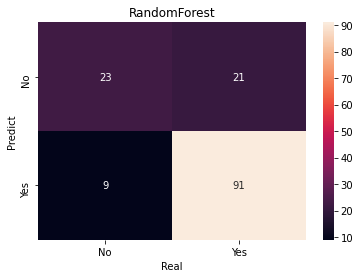

In [20]:
rf = RandomForestClassifier(random_state=42, 
                               n_jobs=4, 
                               n_estimators=50, 
                               max_depth=11,
                               max_features=6)


rf.fit(X_train, y_train)
mod_eval(data_set, rf.predict(X_test), rf.predict_proba(X_test), y_test, 'RandomForest')


## LogisticRegression

              precision    recall  f1-score   support

           0       0.90      0.43      0.58        44
           1       0.80      0.98      0.88       100

    accuracy                           0.81       144
   macro avg       0.85      0.71      0.73       144
weighted avg       0.83      0.81      0.79       144



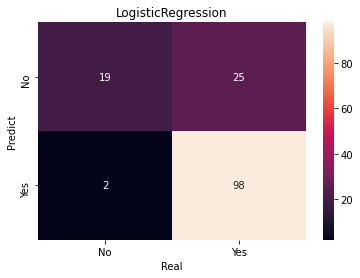

In [21]:
lr = LogisticRegression(C=0.1, 
                       penalty='l1',
                       solver='liblinear',
                       max_iter=1000)
lr.fit(X_train, y_train)
t = 0.71
predprob = lr.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
mod_eval(data_set, pred_y, lr.predict_proba(X_test), y_test, 'LogisticRegression') 

## NaiveBayes

              precision    recall  f1-score   support

           0       0.88      0.50      0.64        44
           1       0.82      0.97      0.89       100

    accuracy                           0.83       144
   macro avg       0.85      0.73      0.76       144
weighted avg       0.83      0.83      0.81       144



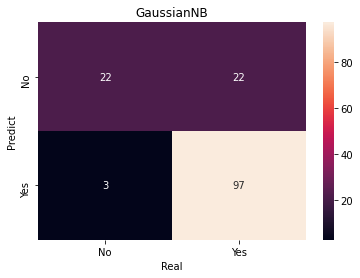

In [22]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)
t = 0.75
predprob = gnb.predict_proba(X_test)
pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
mod_eval(data_set,pred_y, gnb.predict_proba(X_test), y_test, 'GaussianNB')

## SVC

t=0.75
              precision    recall  f1-score   support

           0       0.90      0.43      0.58        44
           1       0.80      0.98      0.88       100

    accuracy                           0.81       144
   macro avg       0.85      0.71      0.73       144
weighted avg       0.83      0.81      0.79       144



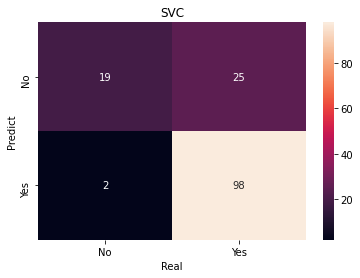

In [23]:
svc = SVC(kernel='linear',
         C=1, 
         gamma='auto',
         class_weight='balanced',
         probability=True)
svc.fit(X_train, y_train)
t=0.75
print('t={}'.format(t))
predprob = svc.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
#pred_y = svc.predict(X_test)

mod_eval(data_set,pred_y, svc.predict_proba(X_test), y_test, 'SVC')
plt.show()

## Adaboost

In [24]:
from sklearn.ensemble import AdaBoostClassifier
boosting = AdaBoostClassifier(n_estimators=100, random_state=0)
boosting.fit(X_train, y_train).score(X_test, y_test)

0.7361111111111112

## Compare Models
- The RandomForest classifier has the best results

In [25]:
# compare final models: accuracy
import sklearn
accuracy_vals=[]
for val in [rf.predict(X_test),
lr.predict(X_test),
gnb.predict(X_test),
svc.predict(X_test)]:
    accuracy_vals.append(sklearn.metrics.accuracy_score(val, y_test.values))
accuracy_vals

[0.7916666666666666, 0.8125, 0.8125, 0.8125]

In [26]:
# compare final models: ROCAUC
roc_vals=[]
for val in [rf.predict(X_test),
            lr.predict(X_test),
            gnb.predict(X_test),
            svc.predict(X_test)]:
    roc_vals.append(sklearn.metrics.roc_auc_score(val, y_test.values))
roc_vals

[0.765625, 0.8507549361207898, 0.8507549361207898, 0.8507549361207898]

In [27]:
# display final values
models = ['random forest', 'linear regression', 'naive bayes', 'support vector', 'dummy']
evaldf = pd.DataFrame(list(zip(models, accuracy_vals, roc_vals)))
evaldf.columns=['model', 'accuracy', 'rocauc']
evaldf=evaldf.set_index('model', drop=True)
evaldf

,accuracy,rocauc
model,,
random forest,0.791667,0.765625
linear regression,0.812500,0.850755
naive bayes,0.812500,0.850755
support vector,0.812500,0.850755


In [28]:
# display results with plotly
trace0 = go.Bar(x= evaldf.index,
                y= evaldf['accuracy'].values,
                name='accuracy',
                marker=dict(color='rgb(100,200,300)'))
trace1 = go.Bar(x= evaldf.index,
                y= evaldf['rocauc'].values,
                name='roc-auc',
                marker=dict(color='rgb(300,200,100)'))
# now the layout
layout=go.Layout(title='Model Comparison',
                   xaxis= dict(title='Model'),
                   yaxis=dict(title='Score'))
# bind using go.Figure
fig = go.Figure(data=[trace0, trace1], layout=layout)
fig

## Take a look at the final results

In [29]:
# Random Forest feature importance
fi_df = pd.DataFrame({'fi': rf.feature_importances_},index=X_train.columns).sort_values(by='fi', ascending=False)
fi_df

,fi
Credit_History,0.292887
ln_total_income,0.254531
ln_monthly_return,0.171479
ln_LoanAmount,0.147454
Education,0.032314
Gender,0.028000
Property_Area_Semiurban,0.026714
Property_Area_Urban,0.023657
Self_Employed,0.022965


In [30]:
# display results with plotly
trace0 = go.Bar(x= fi_df.index,
                y= fi_df['fi'].values,
                marker=dict(color='rgb(100,200,300)'))

# now the layout
layout=go.Layout(title='Feature Importance',
                   xaxis= dict(title='Feature'),
                   yaxis=dict(title='Score'))
# bind using go.Figure
fig = go.Figure(data=[trace0], layout=layout)
fig

In [31]:
# what are the key variables like?
X_test[['Credit_History', 'ln_total_income', 'ln_monthly_return', 'ln_LoanAmount']].sample(3).T

,308,158,299
Credit_History,1.000000,1.000000,1.000000
ln_total_income,-0.084437,-0.740147,-0.726395
ln_monthly_return,-0.426292,-0.197194,-0.086103
ln_LoanAmount,-0.307943,-0.055031,0.067606


## Pickle the model and its preprocessing steps

In [60]:
# pickle the dataframes for visualization
filename = open('approved_loans.pkl', 'wb')
pickle.dump(approved, filename)
filename.close()

In [61]:
# pickle the dataframes for visualization
filename = open('denied_loans.pkl', 'wb')
pickle.dump(denied, filename)
filename.close()

In [42]:
# pickle your random forest model
filename = open('loan_approval_rf_model.pkl', 'wb')
pickle.dump(rf, filename)
filename.close()

In [43]:
# encoder1
filename = open('loan_approval_onehot_encoder.pkl', 'wb')
pickle.dump(encoder1, filename)
filename.close()

In [44]:
# ss_scaler1: monthly_return
filename = open('loan_approval_ss_scaler1.pkl', 'wb')
pickle.dump(ss_scaler1, filename)
filename.close()

In [45]:
# ss_scaler2: ln_total_income
filename = open('loan_approval_total_income.pkl', 'wb')
pickle.dump(ss_scaler2, filename)
filename.close()

In [46]:
# ss_scaler3: loan_amount
filename = open('loan_approval_loan_amount.pkl', 'wb')
pickle.dump(ss_scaler3, filename)
filename.close()